In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

### Metabolic profile of Acute toxicity data

In [3]:
times = pd.read_excel(external_dir/'smi_acute_ivt_metab.xlsx')

In [4]:
times.head()


times = (times
         .assign(Parent = lambda x: x['Chemical name'].ffill())
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

In [6]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [7]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1


In [8]:
len(newlst)

88962

In [9]:
times.shape

(88962, 22)

In [10]:
times['ID'] = newlst

In [11]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefined stereo

[16:36:36] WARNING: Omitted undefi

In [12]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [13]:
times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [14]:
times[['ID of metabolite', 'Level of generation', 'Predecessor ID','Chemical name', 'SMILES','Parent', 'ID']].head()

,ID of metabolite,Level of generation,Predecessor ID,Chemical name,SMILES,Parent,ID
0,1,0,-,DTXSID00142939,CC(=O)OCC#N,DTXSID00142939,DTXSID00142939
1,2,1,1,NaN,CC(O)=O,DTXSID00142939,DTXSID00142939_m_1
2,3,1,1,NaN,N#CCO,DTXSID00142939,DTXSID00142939_m_2
3,4,2,3,NaN,C=O,DTXSID00142939,DTXSID00142939_m_3
4,5,2,3,NaN,C#N,DTXSID00142939,DTXSID00142939_m_4


In [15]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)

In [16]:
times1['mol'] = [Chem.MolFromSmiles(e) for e in times1['SMILES']]

[16:37:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:37:13] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[16:37:13] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[16:37:13] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[16:37:13] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[16:37:13] SMILES Parse Error: syntax error while parsing: [C.]OC1C(O)C(O)C(O)C(CO)O1
[16:37:13] SMILES Parse Error: Failed parsing SMILES '[C.]OC1C(O)C(O)C(O)C(CO)O1' for input: '[C.]OC1C(O)C(O)C(O)C(CO)O1'
[16:37:13] SMILES Parse Error: syntax error while parsing: [C.]
[16:37:13] SMILES Parse Error: Failed parsing SMILES '[C.]' for input: '[C.]'
[16:37:13] SMILES Parse Error: syntax error while parsing: [C.]O
[16:37:13] SMILES Parse Error: Failed parsing SMILES '[C.]O' for input: '[C.]O'
[16:37:13] SMILES Parse Error: syntax error while parsing: [C.]
[16:37:13] SMILES Parse Error: Failed pars

In [17]:
from rdkit.Chem import rdFingerprintGenerator

In [18]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=1024)

In [19]:
times1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88962 entries, 0 to 88961
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_of_metabolite     88962 non-null  int64 
 1   Level_of_generation  88962 non-null  int64 
 2   Predecessor_ID       88962 non-null  object
 3   Chemical_name        6474 non-null   object
 4   SMILES               88962 non-null  object
 5   Parent               88962 non-null  object
 6   Parent_id            6474 non-null   object
 7   ID                   88962 non-null  object
 8   INCHI_KEY            88928 non-null  object
 9   transformation       82488 non-null  object
 10  mol                  88928 non-null  object
dtypes: int64(2), object(9)
memory usage: 7.5+ MB


In [20]:
times1 = (times1
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [21]:
times1 = (times1
 .filter(['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',
       'Chemical_name', 'SMILES', 'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation', 'mol', 'fps'])
)

In [22]:
times1[times1['fps'].isnull()]['Parent'].unique()

array(['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756',
       'DTXSID7073569', 'DTXSID8027747'], dtype=object)

In [23]:
times1 = (times1
 .query("Parent not in ['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756','DTXSID7073569', 'DTXSID8027747']")
       )

In [24]:
transformation_types = times1['transformation'].unique().tolist()
transformation_types = transformation_types[1:]
edges = times1[times1['Predecessor_ID'] != '-']

In [25]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [26]:
n_transformations = len(transformation_types)

In [27]:
n_transformations

85

In [28]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [29]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [30]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['fps'],
            ID = row['ID']
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

In [31]:
graph_dict['DTXSID00142939']

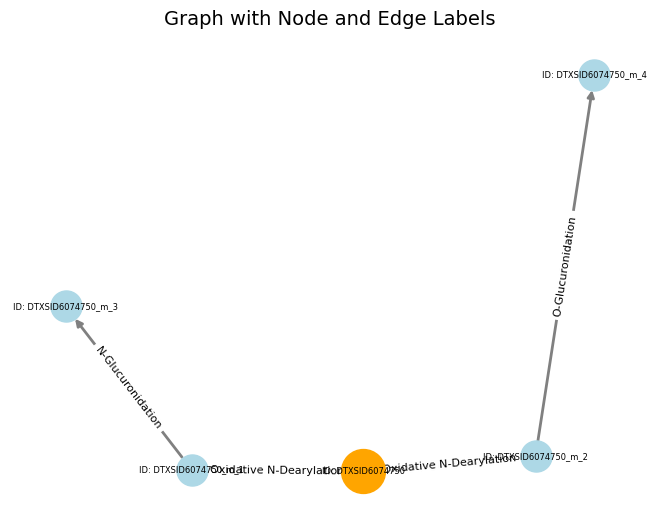

In [32]:
parent_id = "DTXSID6074750"
G = graph_dict[parent_id]


pos = nx.spring_layout(G, k=0.5, seed=42)
# Visualize the graph (optional)
nx.draw(
    G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=6, edge_color='gray', width=2
)

# Draw node labels using a 'label' attribute
node_labels = nx.get_node_attributes(G, 'label')  # Ensure nodes have a 'label' attribute
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)

# Draw edge labels (ensure edges have a 'transformation_type' or similar attribute)
edge_labels = nx.get_edge_attributes(G, 'transformation_type')  # Ensure edges have this attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Make parent nodes stand out (e.g., larger size, different color)
parent_nodes = [node for node, label in node_labels.items() if '_m_' not in label]# Identify parent nodes by condition
nx.draw_networkx_nodes(G, pos, nodelist=parent_nodes, node_color='orange', node_size=1000)

# Optionally, adjust layout with more manual control to avoid overlap
# You can tweak 'pos' manually if you know the specific positions
# Example: pos['Parent'] = [0, 0]  # This sets the 'Parent' node to the center

plt.title("Graph with Node and Edge Labels", fontsize=14)
plt.axis('off')  # Turn off the axis to make the graph clearer
plt.show()



In [33]:
len(graph_dict.keys())

6468

In [34]:
ids = list(graph_dict.keys())

In [35]:
acute = pd.read_csv(external_dir/'small_acute_processed.csv')

In [36]:
acute = (acute
 .rename(columns = {'dsstox_sid': 'dtxsid'})
 .query("dtxsid  in @ids")
)

In [37]:
acute.head(1)

,dtxsid,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,casrn,mol_weight,LD50_LM
0,DTXSID5020281,False,False,460.0,2.0,4.0,100-00-5,157.550003,-0.465339


In [38]:
acute.shape

(6468, 9)

In [39]:
acute = (acute
 .assign(acute_cat = lambda df: df['GHS_category'].apply(lambda x: 1 if x >= 4 else 0))
 
)

In [40]:
acute.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6468 entries, 0 to 7010
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dtxsid        6468 non-null   object 
 1   very_toxic    6468 non-null   bool   
 2   nontoxic      6468 non-null   bool   
 3   LD50_mgkg     6468 non-null   float64
 4   EPA_category  6468 non-null   float64
 5   GHS_category  6468 non-null   float64
 6   casrn         6468 non-null   object 
 7   mol_weight    6468 non-null   float64
 8   LD50_LM       6468 non-null   float64
 9   acute_cat     6468 non-null   int64  
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 467.4+ KB


In [41]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss,BCELoss
from torch_geometric.nn import GCNConv,GATv2Conv,global_mean_pool

In [42]:
def convert_nx_to_pyg(G):
    """
    Converts a NetworkX graph G into a PyTorch Geometric Data object.
    
    Args:
        G (networkx.DiGraph): The input metabolic graph.
        endpoint_df (pd.DataFrame): A DataFrame containing 'ID' and 'endpoint_label' for nodes.

    Returns:
        Data: PyTorch Geometric Data object
    """
    node_ids = list(G.nodes)
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Extract node features and attributes
    node_features = []
    node_chemical_names = []
    node_SMILES = []
    

    for n in node_ids:
        fingerprint_vector = G.nodes[n]['fingerprint'].flatten()
        node_features.append(fingerprint_vector)

        node_chemical_names.append(G.nodes[n]['chemical_name'])
        node_SMILES.append(G.nodes[n]['SMILES'])

        
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Extract edges
    edge_index = []
    edge_features = []
    edge_types = []  # For debugging

    for source, target, data in G.edges(data=True):
        edge_index.append([id_map[source], id_map[target]])

        # Convert sparse one-hot encoding to dense tensor
        sparse_one_hot = data['sparse_one_hot'].toarray().flatten()
        edge_features.append(sparse_one_hot)

        # Store edge transformation type
        edge_types.append(data['transformation_type'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object with extra attributes stored as lists
    return Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        chemical_name=node_chemical_names,
        edge_types=edge_types
    )


In [43]:
class MolDataset(Dataset):
    def __init__(self, df):
        """
        fp1: target column in df of numpy representation of Morgan fp
        fp2: analogue column in df of numpy representation of Morgan fp
        labels: List of 0 (similar) or 1 (dissimilar) for each pair
        """
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        graph = convert_nx_to_pyg(graph_dict[row['dtxsid']])
        identifier = row['dtxsid']
        graph.y = torch.tensor(row['acute_cat'], dtype=torch.long)
        
        return graph

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
acute1 = acute.set_index('dtxsid')

## Quick Baseline

In [46]:
acute_smi = (pd.concat([pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'last')]))

In [47]:
acute_smi = (acute_smi
 .query('QSAR_READY_SMILES.notnull()')
)

In [48]:
acute_smi['mol'] = [Chem.MolFromSmiles(e) for e in acute_smi['QSAR_READY_SMILES']]

In [49]:
acute_smi = (acute_smi
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [50]:
acute_smi.columns

Index(['INPUT', 'FOUND_BY', 'DTXSID', 'PREFERRED_NAME', 'SMILES',
       'QSAR_READY_SMILES', 'mol', 'fps'],
      dtype='object')

In [51]:
acute2 = (acute
 .merge(acute_smi[['DTXSID', 'PREFERRED_NAME', 'QSAR_READY_SMILES','fps']], left_on = 'dtxsid', right_on = 'DTXSID', how = 'left')
)

In [52]:
acute2.acute_cat.unique()

array([1, 0])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(acute2, acute2['acute_cat'], stratify = acute2['acute_cat'], test_size = 0.2)

In [54]:
# Now, split the remaining 20% into 10% validation and 10% test
val_data, test_data = train_test_split(X_test, stratify =X_test['acute_cat'], test_size=0.5, random_state=42)

In [55]:
train_data = MolDataset(X_train)

In [56]:
train_data[0].y.shape

/tmp/ipykernel_83819/457895678.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  node_features = torch.tensor(node_features, dtype=torch.float)


torch.Size([])

In [57]:
val_data = MolDataset(val_data)
test_data = MolDataset(test_data)

In [58]:
from torch_geometric.loader import DataLoader  # Use this one!

train_loader = DataLoader(train_data, batch_size = 300, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 300, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 300, shuffle = False)

In [110]:
from torch.utils.data import ConcatDataset
full_train_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])

In [111]:
full_train_dataset[0].num_features

1024

In [112]:
len(full_train_dataset)

5821

In [114]:
full_train_loader = DataLoader(full_train_dataset, batch_size=300, shuffle=True)


In [115]:
full_train_loader

In [113]:
for batch in full_train_dataset:
    print(type(batch))  # Should output <class 'torch_geometric.data.Batch'>
    print(batch)  # Inspect the structure
    break

<class 'torch_geometric.data.data.Data'>
Data(x=[25, 1024], edge_index=[2, 24], edge_attr=[24, 85], chemical_name=[25], edge_types=[24], y=1)


In [61]:
for batch in train_loader:
    print(type(batch))  # Should output <class 'torch_geometric.data.Batch'>
    print(batch)  # Inspect the structure
    break

/tmp/ipykernel_83819/457895678.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  edge_index = torch.tensor(edge_index, dtype=torch.long).T


<class 'abc.DataBatch'>
DataBatch(x=[4055, 1024], edge_index=[2, 3755], edge_attr=[3755, 85], chemical_name=[300], edge_types=[300], y=[300], batch=[4055], ptr=[301])


In [62]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [63]:
embedding_size = 256
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(1024, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 2)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(self.conv1(hidden, edge_index))
        hidden = F.relu(self.conv2(hidden, edge_index))
        hidden = F.relu(self.conv3(hidden, edge_index))

        # Global Pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Classifier (Linear)
        out = self.out(hidden)

        #print("Output shape:", out.shape)  # Debugging
        return out, hidden

In [64]:
model1 = GCN()
print(model1)

GCN(
  (initial_conv): GCNConv(1024, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=512, out_features=2, bias=True)
)


In [65]:
import warnings
warnings.filterwarnings("ignore")
import time

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
print(device)

cuda:0


In [68]:
model1.to(device)

GCN(
  (initial_conv): GCNConv(1024, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=512, out_features=2, bias=True)
)

In [69]:
next(model1.parameters()).device

device(type='cuda', index=0)

In [70]:
from sklearn.metrics import balanced_accuracy_score

In [74]:
def train(model, loader):
# Enumerate over the data
    def balanced_accuracy(pred, true):
            pred_classes = pred.argmax(dim=1).cpu().numpy()  # Convert logits to predicted class
            true_labels = true.cpu().numpy()  # Convert true labels to numpy
            return balanced_accuracy_score(true_labels, pred_classes) 
# Root mean squared error
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007) 
    total_loss = 0
    total_bal_acc = 0


    model.train()
    for data in loader:
    # Reset gradients
        data.to(device)
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        out,embedding = model(data.x,data.edge_index,data.batch)
       
        # Calculating the loss and gradients
        loss = loss_fn(out, data.y)     
        loss.backward()  
    # Update using the gradients
        optimizer.step()   
        # Compute accuracy
        #pred_classes = out.argmax(dim=1)  # Convert logits to class predictions
        bal_acc = balanced_accuracy(out, data.y)

        total_loss += loss.item()
        total_bal_acc += bal_acc

    avg_loss = total_loss / len(loader)
    avg_bal_acc = total_bal_acc / len(loader)

    return avg_loss, avg_bal_acc, out, data.y, embedding
        
    

In [75]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [77]:

epochs = 200
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = np.inf  # Track best validation loss
early_stop_counter = 0  # Track how many epochs we haven't improved
 


print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
balanced_accuracies = []
outputs = []
targets = []

for epoch in range(epochs):
    train_loss, train_bal_acc, pred, target, h= train(model1, train_loader)
    val_loss, val_bal_acc, _, _, _ = train(model1, val_loader)  # Validation loss
    losses.append(train_loss)
    balanced_accuracies.append(train_bal_acc)
    outputs.append(pred)
    targets.append(target)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
    else:
        early_stop_counter += 1  # Increment if no improvement

    if early_stop_counter >= patience:
        print("\nEarly stopping triggered. Stopping training.")
        break

print("\nTraining done!\n")
elapsed = time.time() - start_time
print(f"--- training took {elapsed // 60:.0f} minutes ---")



======== Starting training ... =======


Early stopping triggered. Stopping training.

Training done!

--- training took 3 minutes ---


In [78]:

results = pd.concat([pd.DataFrame(losses),
                     pd.DataFrame(balanced_accuracies)
                    ] ,axis= 1)
results.columns = ['losses', 'balanced_accuracy']
results.head()

,losses,balanced_accuracy
0,0.381566,0.723789
1,0.317959,0.782574
2,0.248113,0.848666
3,0.178243,0.893092
4,0.121698,0.937381


In [91]:
#results

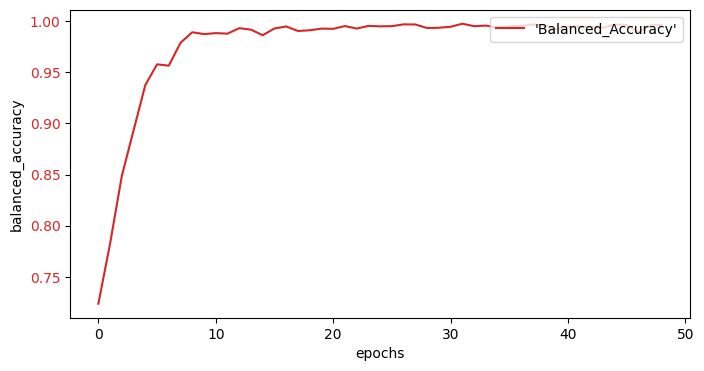

In [80]:
fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.balanced_accuracy, label="'Balanced_Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')


plt.show()
fig.tight_layout()

In [81]:
model1.eval()

# Get predictions from the trained GCN
y_true, y_pred = [], []
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred, _ = model1(batch.x.float(), batch.edge_index, batch.batch)
    
    y_true.extend(batch.y.cpu().numpy())
    y_pred.extend(pred.argmax(dim=1).cpu().numpy())

# Compute balanced accuracy
gcn_bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"GCN Balanced Accuracy: {gcn_bal_acc:.4f}")

GCN Balanced Accuracy: 0.6595


In [106]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_bal_acc = 0.0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            out, _ = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)

            bal_acc = balanced_accuracy_score(data.y.cpu().numpy(), out.argmax(dim=1).cpu().numpy())

            total_loss += loss.item()
            total_bal_acc += bal_acc

    avg_loss = total_loss / len(loader)
    avg_bal_acc = total_bal_acc / len(loader)

    return avg_loss, avg_bal_acc

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
class GCN(torch.nn.Module):
    def __init__(self, embedding_size):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.initial_conv = GCNConv(1024, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.out = torch.nn.Linear(embedding_size * 2, 2)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
        out = self.out(hidden)
        return out, hidden


In [124]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_bal_acc = 0.0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        out, embedding = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)

        loss.backward()
        optimizer.step()

        bal_acc = balanced_accuracy_score(data.y.cpu().numpy(), out.argmax(dim=1).cpu().numpy())

        total_loss += loss.item()
        total_bal_acc += bal_acc

    avg_loss = total_loss / len(loader)
    avg_bal_acc = total_bal_acc / len(loader)

    return avg_loss, avg_bal_acc

In [95]:
import optuna

In [107]:
def objective(trial):
    # Hyperparameter search space
    embedding_size = trial.suggest_int('embedding_size', 64, 512, step=64)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    patience = 10  # Early stopping patience
    epochs = 200

    # Initialize model, optimizer, and loss function
    model = GCN(embedding_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(epochs):
        train_loss, train_bal_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_bal_acc = validate(model, val_loader, criterion, device)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return val_bal_acc  # Optuna will maximize this
# Start Optuna optimization
study = optuna.create_study(storage="sqlite:///optuna_gcn_acute.db", direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-03-14 21:52:44,026] A new study created in RDB with name: no-name-fdcc6c68-b764-4091-b016-408b748dae26
[I 2025-03-14 21:53:55,589] Trial 0 finished with value: 0.6996634207623972 and parameters: {'embedding_size': 384, 'lr': 8.276381084460159e-05, 'weight_decay': 0.00011357211772935764}. Best is trial 0 with value: 0.6996634207623972.


Early stopping at epoch 15


[I 2025-03-14 21:55:25,211] Trial 1 finished with value: 0.6968100333043733 and parameters: {'embedding_size': 192, 'lr': 8.906111482871218e-05, 'weight_decay': 0.0009562188186317254}. Best is trial 0 with value: 0.6996634207623972.


Early stopping at epoch 19


[I 2025-03-14 22:03:13,763] Trial 2 finished with value: 0.6758532813079169 and parameters: {'embedding_size': 64, 'lr': 1.8462015941081487e-05, 'weight_decay': 0.004533848579153954}. Best is trial 0 with value: 0.6996634207623972.


Early stopping at epoch 103


[I 2025-03-14 22:09:36,626] Trial 3 finished with value: 0.6913730226481656 and parameters: {'embedding_size': 256, 'lr': 1.4420424179417549e-05, 'weight_decay': 0.00792638975932323}. Best is trial 0 with value: 0.6996634207623972.


Early stopping at epoch 84


[I 2025-03-14 22:11:15,879] Trial 4 finished with value: 0.710248395315051 and parameters: {'embedding_size': 448, 'lr': 3.8057006124590484e-05, 'weight_decay': 3.8720610328304296e-05}. Best is trial 4 with value: 0.710248395315051.


Early stopping at epoch 21


[I 2025-03-14 22:22:09,862] Trial 5 finished with value: 0.6704388726023263 and parameters: {'embedding_size': 64, 'lr': 1.0835126832413845e-05, 'weight_decay': 0.00045752992224318696}. Best is trial 4 with value: 0.710248395315051.


Early stopping at epoch 145


[I 2025-03-14 22:23:22,280] Trial 6 finished with value: 0.6968167783210965 and parameters: {'embedding_size': 128, 'lr': 0.0003038100979564079, 'weight_decay': 0.0035279469127745167}. Best is trial 4 with value: 0.710248395315051.


Early stopping at epoch 15


[I 2025-03-14 22:24:57,459] Trial 7 finished with value: 0.7161825435194203 and parameters: {'embedding_size': 512, 'lr': 4.160966185050644e-05, 'weight_decay': 4.234718506029633e-05}. Best is trial 7 with value: 0.7161825435194203.


Early stopping at epoch 20


[I 2025-03-14 22:26:19,096] Trial 8 finished with value: 0.707769512512384 and parameters: {'embedding_size': 512, 'lr': 0.004524848038663568, 'weight_decay': 0.009034752869332245}. Best is trial 7 with value: 0.7161825435194203.


Early stopping at epoch 17


[I 2025-03-14 22:27:17,633] Trial 9 finished with value: 0.7252211012672998 and parameters: {'embedding_size': 512, 'lr': 0.0015900965570188456, 'weight_decay': 0.0017425341574867105}. Best is trial 9 with value: 0.7252211012672998.


Early stopping at epoch 12


[I 2025-03-14 22:28:15,663] Trial 10 finished with value: 0.6713862974178743 and parameters: {'embedding_size': 320, 'lr': 0.004334919919947072, 'weight_decay': 0.0012701869675170458}. Best is trial 9 with value: 0.7252211012672998.


Early stopping at epoch 12


[I 2025-03-14 22:29:05,609] Trial 11 finished with value: 0.683810856223653 and parameters: {'embedding_size': 512, 'lr': 0.0008868636529854332, 'weight_decay': 1.2121872303672992e-05}. Best is trial 9 with value: 0.7252211012672998.


Early stopping at epoch 10


[I 2025-03-14 22:29:59,908] Trial 12 finished with value: 0.6961572013744549 and parameters: {'embedding_size': 384, 'lr': 0.000988768300770382, 'weight_decay': 0.00011000796740688617}. Best is trial 9 with value: 0.7252211012672998.


Early stopping at epoch 11


[I 2025-03-14 22:30:59,392] Trial 13 finished with value: 0.6963861037186616 and parameters: {'embedding_size': 512, 'lr': 0.0009895825584848139, 'weight_decay': 1.1035393100139056e-05}. Best is trial 9 with value: 0.7252211012672998.


Early stopping at epoch 12


[I 2025-03-14 22:31:58,283] Trial 14 finished with value: 0.7258449439576816 and parameters: {'embedding_size': 448, 'lr': 0.0002835385591468637, 'weight_decay': 0.00014019482997417143}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 12


[I 2025-03-14 22:32:52,540] Trial 15 finished with value: 0.6775834950505942 and parameters: {'embedding_size': 384, 'lr': 0.00032854700108461726, 'weight_decay': 0.00029957796777127624}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 11


[I 2025-03-14 22:33:42,183] Trial 16 finished with value: 0.7112975988660913 and parameters: {'embedding_size': 448, 'lr': 0.0018273116471430764, 'weight_decay': 0.0013574968817490567}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 10


[I 2025-03-14 22:34:40,509] Trial 17 finished with value: 0.7136074034317548 and parameters: {'embedding_size': 448, 'lr': 0.0002967493961457668, 'weight_decay': 0.0002999850732517741}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 12


[I 2025-03-14 22:35:33,078] Trial 18 finished with value: 0.7189651578479355 and parameters: {'embedding_size': 320, 'lr': 0.009579906075114606, 'weight_decay': 0.00013238224494248934}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 11


[I 2025-03-14 22:36:35,324] Trial 19 finished with value: 0.7047719001005571 and parameters: {'embedding_size': 448, 'lr': 0.000153300940222675, 'weight_decay': 0.0006839307310789426}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 13


[I 2025-03-14 22:37:29,212] Trial 20 finished with value: 0.6963170907583142 and parameters: {'embedding_size': 256, 'lr': 0.0022252497602397595, 'weight_decay': 0.0021476987922665713}. Best is trial 14 with value: 0.7258449439576816.


Early stopping at epoch 11


[I 2025-03-14 22:38:23,653] Trial 21 finished with value: 0.7325022324128811 and parameters: {'embedding_size': 320, 'lr': 0.008821016850721133, 'weight_decay': 0.00014187140526655852}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 11


[I 2025-03-14 22:39:26,712] Trial 22 finished with value: 0.711847683788981 and parameters: {'embedding_size': 384, 'lr': 0.008764784669945446, 'weight_decay': 0.00019914197616461836}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 13


[I 2025-03-14 22:40:25,084] Trial 23 finished with value: 0.7029677710137662 and parameters: {'embedding_size': 320, 'lr': 0.0005825023504418118, 'weight_decay': 7.122869744377811e-05}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 12


[I 2025-03-14 22:41:14,847] Trial 24 finished with value: 0.7061338579399545 and parameters: {'embedding_size': 448, 'lr': 0.0025335732636433323, 'weight_decay': 3.9074697619028184e-05}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 10


[I 2025-03-14 22:42:08,651] Trial 25 finished with value: 0.7095568707648856 and parameters: {'embedding_size': 192, 'lr': 0.004073229177805548, 'weight_decay': 0.0005625931173301148}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 11


[I 2025-03-14 22:43:07,275] Trial 26 finished with value: 0.6960244620189465 and parameters: {'embedding_size': 512, 'lr': 0.0005228877076287156, 'weight_decay': 0.00018451233943884372}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 12


[I 2025-03-14 22:43:56,565] Trial 27 finished with value: 0.700542240513422 and parameters: {'embedding_size': 384, 'lr': 0.001537556578941137, 'weight_decay': 5.849121139775817e-05}. Best is trial 21 with value: 0.7325022324128811.


Early stopping at epoch 10


[I 2025-03-14 22:44:50,747] Trial 28 finished with value: 0.7550677085036185 and parameters: {'embedding_size': 256, 'lr': 0.006605715072216298, 'weight_decay': 2.520332970217676e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:45:40,074] Trial 29 finished with value: 0.7242287210645341 and parameters: {'embedding_size': 192, 'lr': 0.006567463828453215, 'weight_decay': 2.058555691990683e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 10


[I 2025-03-14 22:46:52,740] Trial 30 finished with value: 0.6925903413063113 and parameters: {'embedding_size': 256, 'lr': 0.00015771988453017964, 'weight_decay': 9.432199241202293e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 15


[I 2025-03-14 22:47:47,407] Trial 31 finished with value: 0.7357747553436301 and parameters: {'embedding_size': 320, 'lr': 0.003161589430757472, 'weight_decay': 2.091421557864051e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:48:46,156] Trial 32 finished with value: 0.7000469795958981 and parameters: {'embedding_size': 320, 'lr': 0.005729581335394861, 'weight_decay': 2.512591025320831e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 12


[I 2025-03-14 22:49:40,114] Trial 33 finished with value: 0.7178014289370128 and parameters: {'embedding_size': 256, 'lr': 0.0034060848247264757, 'weight_decay': 1.8559848516768604e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:50:34,139] Trial 34 finished with value: 0.7239806398165598 and parameters: {'embedding_size': 192, 'lr': 0.009883810206833122, 'weight_decay': 6.585174793371147e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:51:28,660] Trial 35 finished with value: 0.7172403818795172 and parameters: {'embedding_size': 128, 'lr': 0.0029158528310002456, 'weight_decay': 2.5632930532727683e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:52:22,593] Trial 36 finished with value: 0.7150969908440228 and parameters: {'embedding_size': 320, 'lr': 0.006389139868090341, 'weight_decay': 0.00018949153762590386}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 22:53:43,804] Trial 37 finished with value: 0.6937855716388123 and parameters: {'embedding_size': 256, 'lr': 0.00010136319801883611, 'weight_decay': 1.564571436457471e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 17


[I 2025-03-14 22:56:46,696] Trial 38 finished with value: 0.660979858034554 and parameters: {'embedding_size': 128, 'lr': 3.4430093282141154e-05, 'weight_decay': 3.04584312942948e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 40


[I 2025-03-14 22:57:49,248] Trial 39 finished with value: 0.7242383738236823 and parameters: {'embedding_size': 320, 'lr': 0.00020976362708123613, 'weight_decay': 4.916418621643521e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 13


[I 2025-03-14 22:59:09,459] Trial 40 finished with value: 0.6988271738037967 and parameters: {'embedding_size': 384, 'lr': 6.125377875521397e-05, 'weight_decay': 0.0004001979365928367}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 17


[I 2025-03-14 23:00:12,756] Trial 41 finished with value: 0.7123714076129145 and parameters: {'embedding_size': 448, 'lr': 0.0013223187345327942, 'weight_decay': 0.003064116061638686}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 13


[I 2025-03-14 23:01:34,260] Trial 42 finished with value: 0.718808485894788 and parameters: {'embedding_size': 512, 'lr': 0.005447477839282724, 'weight_decay': 0.0009118451519089973}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 17


[I 2025-03-14 23:02:32,294] Trial 43 finished with value: 0.6935984841466706 and parameters: {'embedding_size': 256, 'lr': 0.0004966858501667399, 'weight_decay': 8.429136281157905e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 12


[I 2025-03-14 23:04:05,770] Trial 44 finished with value: 0.6935063781126981 and parameters: {'embedding_size': 320, 'lr': 0.0039166631005204235, 'weight_decay': 0.006704218502487134}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 20


[I 2025-03-14 23:04:59,875] Trial 45 finished with value: 0.6995842962381221 and parameters: {'embedding_size': 384, 'lr': 0.002015492118462609, 'weight_decay': 0.00012761439130499566}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 11


[I 2025-03-14 23:05:49,644] Trial 46 finished with value: 0.6990308472872065 and parameters: {'embedding_size': 512, 'lr': 0.0007811630330145949, 'weight_decay': 3.5126772127462006e-05}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 10


[I 2025-03-14 23:06:52,237] Trial 47 finished with value: 0.7362531481982594 and parameters: {'embedding_size': 192, 'lr': 0.007536718805850307, 'weight_decay': 0.00022839024475103191}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 13


[I 2025-03-14 23:07:42,444] Trial 48 finished with value: 0.7429786899535807 and parameters: {'embedding_size': 192, 'lr': 0.00805724760608631, 'weight_decay': 0.00016717393122148787}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 10


[I 2025-03-14 23:08:32,370] Trial 49 finished with value: 0.7057126546619465 and parameters: {'embedding_size': 192, 'lr': 0.0073132797141081144, 'weight_decay': 0.0002102553729991571}. Best is trial 28 with value: 0.7550677085036185.


Early stopping at epoch 10
Best hyperparameters: {'embedding_size': 256, 'lr': 0.006605715072216298, 'weight_decay': 2.520332970217676e-05}


In [108]:
best_params = study.best_params
print(best_params)

{'embedding_size': 256, 'lr': 0.006605715072216298, 'weight_decay': 2.520332970217676e-05}


In [125]:
best_model = GCN(best_params['embedding_size']).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = torch.nn.CrossEntropyLoss()


In [127]:
epochs = 200  # Same as before

for epoch in range(epochs):
    best_model.train()
    train_loss, train_bal_acc = train(best_model, full_train_loader,optimizer, criterion, device)  # Use full train + val data

print("Training complete.")

Training complete.


Trial 28 finished with value: 0.7550677085036185 and parameters: {'embedding_size': 256, 'lr': 0.006605715072216298, 'weight_decay': 2.520332970217676e-05}. Best is trial 28 with value: 0.7550677085036185.

Early stopping at epoch 11


In [128]:
best_model.eval()
with torch.no_grad():
    test_loss, test_bal_acc = validate(best_model, test_loader,criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Balanced Accuracy: {test_bal_acc:.4f}")



Test Loss: 2.0472, Test Balanced Accuracy: 0.7416


In [129]:
torch.save(best_model.state_dict(), "best_gcn_model.pth")

In [130]:
X_train1 = np.vstack(X_train['fps'].values)


In [131]:
X_test1 = np.vstack(X_test['fps'].values)

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)
cv = StratifiedKFold(n_splits = 10)

In [133]:

from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
scorer = make_scorer(balanced_accuracy_score)

In [134]:
cv_results = cross_validate(rfc, X_train1, y_train , cv=cv, scoring=scorer, return_train_score = True)

In [135]:
cv_results

{'fit_time': array([0.86162877, 0.79341125, 0.79047728, 0.78865361, 0.78166151,
        0.79199576, 0.77581739, 0.75595665, 0.78312612, 0.78116679]),
 'score_time': array([0.00779581, 0.00745964, 0.00733709, 0.00745392, 0.00748849,
        0.00772429, 0.00728989, 0.00731444, 0.00733852, 0.0072906 ]),
 'test_score': array([0.68542694, 0.66842665, 0.67170486, 0.68454695, 0.71828845,
        0.69851136, 0.6481431 , 0.71045556, 0.6906147 , 0.70913322]),
 'train_score': array([0.98443309, 0.98416535, 0.98375247, 0.98622976, 0.98500338,
        0.98238299, 0.9847131 , 0.98391089, 0.98304944, 0.98319453])}

In [136]:
cv_results['test_score'].mean()

0.6885251785717564

In [137]:
rfc.fit(X_train1, y_train)
y_pred = rfc.predict(X_test1)

In [138]:
balanced_accuracy_score(y_test, y_pred)

0.6729207556998409

Extract embeddings

In [139]:
def extract_embeddings(model, loader, device):
    model.eval()  # Set model to eval mode
    embeddings = []
    labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in loader:
            batch.to(device)
            _, embedding = model(batch.x.float(), batch.edge_index, batch.batch)  
            embeddings.append(embedding.cpu())  # Move to CPU if needed
            labels.append(batch.y.cpu())  # Store labels for reference

    embeddings = torch.cat(embeddings, dim=0)  # Combine all batches
    labels = torch.cat(labels, dim=0)

    return embeddings.numpy(), labels.numpy()  # Convert to NumPy for easy use

In [140]:
embeddings, labels = extract_embeddings(best_model, test_loader, device)
print("Embeddings shape:", embeddings.shape)  # Should be (num_samples, embedding_size)
print("Labels shape:", labels.shape)

Embeddings shape: (647, 512)
Labels shape: (647,)


In [141]:
import umap

In [142]:
def umap_plot(a):
    model = umap.UMAP(random_state=42, n_jobs = 1)
    #model = TSNE(learning_rate = 200, perplexity=a[label].shape[0]-1, random_state = 42)
    umap_features = model.fit_transform(a)
    umap_features = pd.DataFrame(umap_features,columns = ['umap_x', 'umap_y'])
    #umap_df = pd.concat([umap_features, b[label]], axis = 1)
    return umap_features

In [143]:
umap_df = pd.concat([umap_plot(embeddings), pd.Series(labels)], axis = 1)

In [146]:
umap_df = (umap_df
 .rename(columns = {0:'acutetox_label'})
)

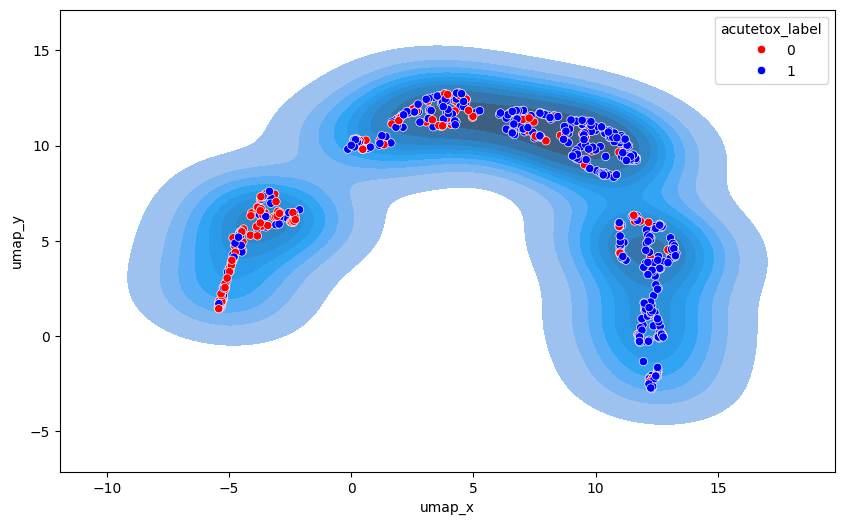

In [148]:
fig, ax= plt.subplots(figsize = (10,6))
color_dict = dict({1:'blue', 0:'red'})
sns.kdeplot(x = 'umap_x', y = 'umap_y', fill = True,data = umap_df, ax = ax)
sns.scatterplot(x = 'umap_x', y = 'umap_y', hue = 'acutetox_label', palette = color_dict, data = umap_df, ax = ax)
ax1.set_ylabel('UMAP (Second Dimension)')
ax1.set_xlabel('UMAP (First Dimension)')
fig.savefig('UMAP_acute.png', dpi = 300)

In [149]:
mrgn_df = np.concatenate([X_train1, X_test1])

In [150]:
mrgn_umap_df = pd.concat([umap_plot(mrgn_df), pd.Series(labels)], axis = 1)

In [151]:
mrgn_umap_df = (mrgn_umap_df
 .rename(columns = {0:'acutetox_label'})
)

Text(0.5, 14.722222222222216, 'UMAP (First Dimension)')

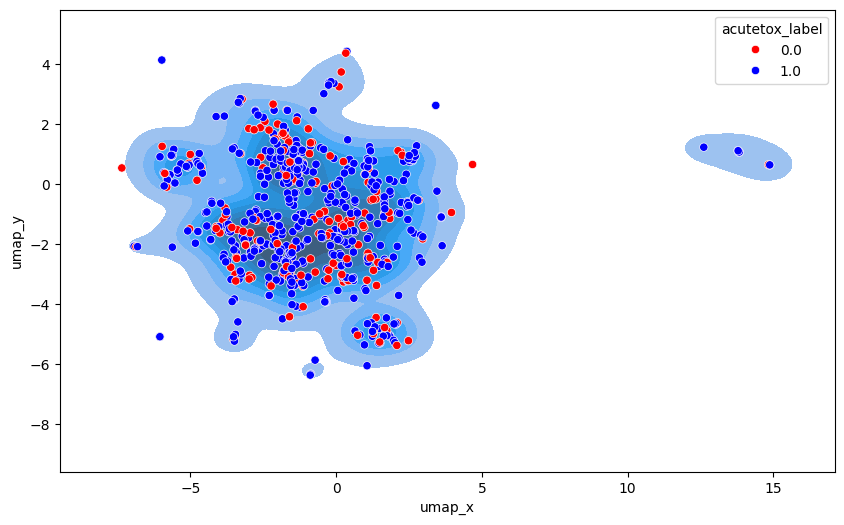

In [152]:
fig, ax= plt.subplots(figsize = (10,6))
color_dict = dict({1:'blue', 0:'red'})
sns.kdeplot(x = 'umap_x', y = 'umap_y', fill = True,data = mrgn_umap_df, ax = ax)
sns.scatterplot(x = 'umap_x', y = 'umap_y', hue = 'acutetox_label', palette = color_dict, data = mrgn_umap_df, ax = ax)
ax1.set_ylabel('UMAP (Second Dimension)')
ax1.set_xlabel('UMAP (First Dimension)')